#### Install dependencies.
We only need minimal dependencies, `xarray` and `zarr` to access hindcasts

In [1]:
!pip3 install xarray zarr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 13.8 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5033 sha256=299b81413f08581107aaebb6c0840941e8e69e89ddb73db50478249b2241a381
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree


In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import datetime
import numpy as np
import datetime

#### Setup access to hindcasts.

All hindcasts are stored on Google Cloud Storage buckets for easy access.
Please contact vivek@excarta.io for access to hindcast.
Once you have access to the storage bucket, update _HINDCAST_BUCKET with the
correct value.

48-hour hindcasts are available immediately for 2021, 2022, and 2023. Longer hindcasts can be produced as needed.

In [ ]:
_HINDCAST_BUCKET = 'excarta_storage_bucket'

#### Load a specific hindcast.
All hindcasts are stored as Cloud-friendly Zarr files, and for any given date
the hindcast is available at `_HINDCAST_BUCKET/YYYY/YYYYMMDD.zarr`
The hindcast can be accessed anywhere using the https:// URL, though
the GCS URI `gs://_HINDCAST_PATH/YYYY/YYYYMMDD.zarr` if running from a GCP environment.


In [3]:
ISSUE_DATE = datetime.datetime(2023, 1, 1)
forecast = xr.open_zarr(ISSUE_DATE.strftime(
    f'https://storage.googleapis.com/{_HINDCAST_BUCKET}/%Y/%Y%m%d.zarr'))

#### Available cordinates
Coordinates make it easy to access any specific time, longitude, or latitude in the
hindcast. Zarr datasets also do "lazy loading", so only the data you specifically
request is loaded. This allows for fast, lightweight access to tailored hindcasts without
needing to download the entire dataset.

In [4]:
forecast.coords

Coordinates:
  * latitude              (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75
  * longitude             (longitude) float64 0.0 0.25 0.5 ... 359.2 359.5 359.8
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 01:00:00 ......

#### Avaiable variables
Several essential variables are available in all hindcasts. Please contact vivek@excarta.io for other variables of interest.

In [5]:
forecast.data_vars

Data variables:
    100m_wind_speed          (prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 72, 144), meta=np.ndarray>
    100m_wind_speed_angle    (prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 72, 144), meta=np.ndarray>
    10m_wind_speed           (prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 72, 144), meta=np.ndarray>
    10m_wind_speed_angle     (prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 72, 144), meta=np.ndarray>
    2m_dewpoint_temperature  (prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 72, 144), meta=np.ndarray>
    2m_temperature           (prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 72, 144), meta=np.ndarray>
    dhi                      (prediction_timedelta, latitude, longitude) float64 dask.array<chunksize=(1, 72, 144), meta=np.ndarray>
    dni                      (prediction_timedelta, l

#### Load the global forecast for a specific time
The `prediction_timedelta` coordinate can be used to specify how far out you want
to fetch the forecast for. For instance, a forecast 6 hours in the future corresponds
to `prediction_timedelta=datetime.timedelta(hours=6)`.

We can use Xarray's `.sel` functionality to easily access the forecast `H` hours ahead:
```
value = forecast[variable_name].sel(
    prediction_timedelta=datetime.timedelta(hours=H))
```

Here we plot the 100-meter wind speeds forecasted 36 hours ahead. Since the
forecast was issued on 2023-01-01 00:00 UTC, this forecast corresponds to the
time 2023-01-02 12:00UTC


Forecast for: 2023-01-02 12:00:00


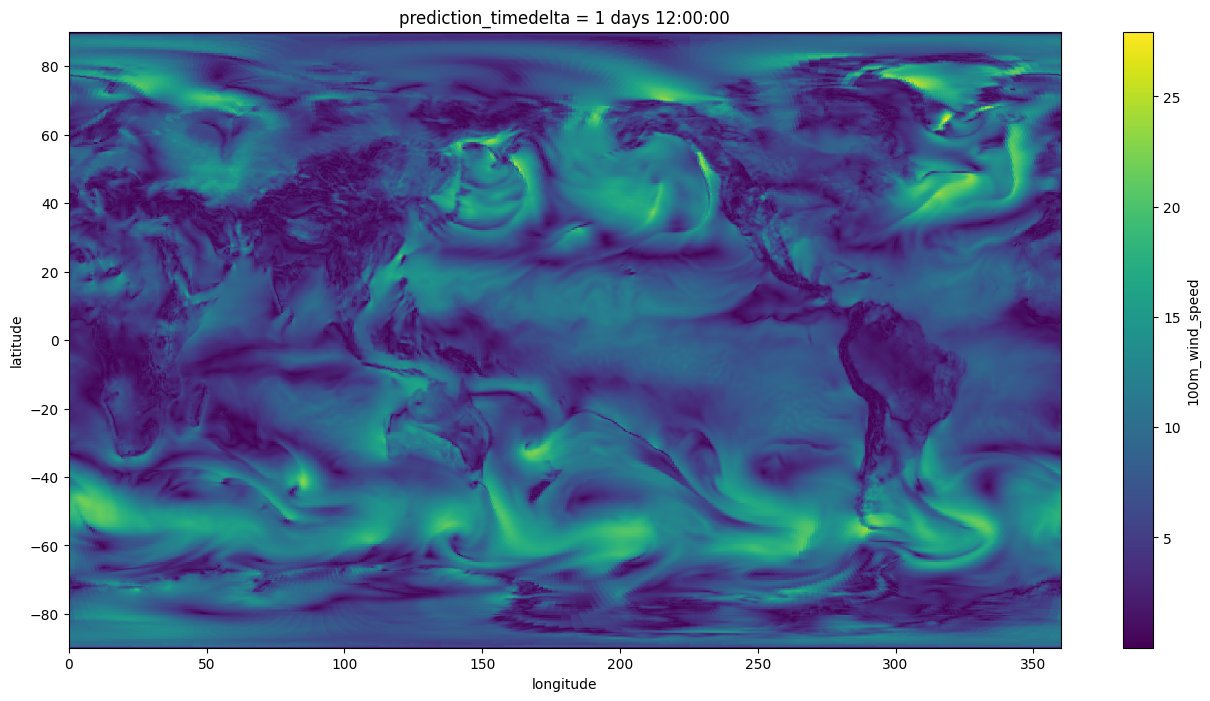

In [6]:
# Plot the wind speeds at 100m, for 36 hours ahead in the forecast issued at 2023-01-01:00UTC
hours_ahead = datetime.timedelta(hours=36)
print(f'Forecast for: {ISSUE_DATE + hours_ahead}')
(forecast['100m_wind_speed'].sel(prediction_timedelta=hours_ahead)).plot.imshow(aspect=2, size=8)

#### Accessing hindcasts for a specific location.
A forecast for a specific locatoin can similarly be accessed using Xarray's `interp`
and `sel` functionality:
```
  value = forecast[variable_name].sel(
    prediction_timedelta=datetime.timedelta(hours=H)).interp(
      latitude=<lat>, longitude=<lon>)
```

Here we plot the forecasted 100-meter wind speeds Lubbock, Texas for the
entire 48 hours available in the hindcast for 2023-01-01.
Note that the longitude is from 0-360 degrees, so we convert the longitude
from `-101.8456` to `360-101.8456`.

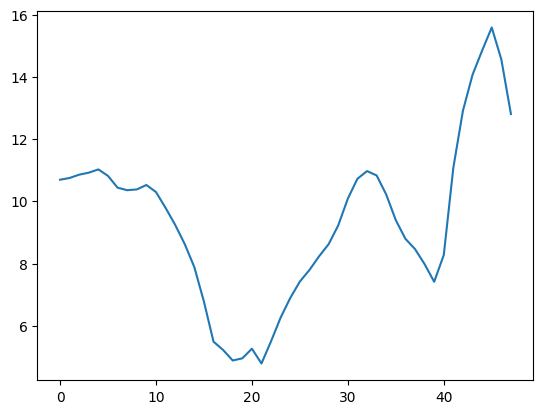

In [10]:
start_hour = datetime.timedelta(hours=1)
end_hour = datetime.timedelta(hours=48)
lubbock_lat, lubbock_lon = 33.5846, 360-101.8456
forecasted_speeds = forecast['100m_wind_speed'].sel(
    prediction_timedelta=slice(start_hour, end_hour)).interp(
    latitude=lubbock_lat,
    longitude=lubbock_lon
)
plt.plot(forecasted_speeds)